1. 프로젝트 소개 & 평가 지표(RMSLE) 설명

2. 라이브러리 로드 & 데이터 불러오기

3. 데이터 구조 파악 & 기본 전처리 (EDA 1단계)

4. 피처 엔지니어링

5. 탐색적 데이터 분석(EDA 2단계, 질문별 분석)

6. 모델링 준비(데이터 분리, 평가 지표 함수 정의)

7. 여러 모델 실험 & RMSLE 비교

8. 최종 모델 선택 & test 예측

9. 인사이트 정리 & 운영 전략 제안 (PDF 보고서 첨부)

# 1. 프로젝트 소개 및 평가 지표(RMSLE)

## 1.1 미션 배경

이 프로젝트에서는 **자전거 대여 시스템의 운영 담당자**라는 가상의 역할을 맡아,  
자전거 대여 수요를 예측하고 운영 전략을 세우는 것을 목표로 한다.

- 목표 1: **자전거 대여 수요를 정확히 예측**하는 모델 구축  
- 목표 2: 예측 결과를 활용해  
  - 시간대·계절·날씨별 **자전거 배치 전략** 수립  
  - **운영 효율성** 향상 및 **사용자 만족도 제고**

최종적으로는 다양한 머신러닝 모델과 피처 엔지니어링 방법을 실험하고,  
**RMSLE(Root Mean Squared Logarithmic Error)를 최소화하는 모델**을 찾는 것이 핵심 미션이다.

---

## 1.2 데이터 소개

분석에 사용할 데이터는 특정 도시의 자전거 대여 기록으로,  
**날짜·시간, 계절, 날씨, 온도, 습도 등** 다양한 변수를 포함하고 있다.

주요 파일은 다음과 같다.

- `train.csv`  
  - 자전거 대여 기록 + 실제 대여 수(`count`)가 포함된 학습용 데이터
- `test.csv`  
  - 동일한 특성(날씨, 시간 등)을 가지지만, **`count`가 없는** 예측용 데이터

주요 컬럼은 다음과 같다.

| 컬럼명      | 타입      | 설명 |
|------------|-----------|------|
| `datetime` | datetime  | 대여 시점 (예: 2011-01-01 00:00:00) |
| `season`   | int       | 계절 (1: 봄, 2: 여름, 3: 가을, 4: 겨울) |
| `holiday`  | int       | 공휴일 여부 (0: 평일, 1: 공휴일) |
| `workingday` | int     | 근무일 여부 (0: 주말/공휴일, 1: 근무일) |
| `weather`  | int       | 날씨 (1: 맑음, 2: 구름/안개, 3: 비/눈, 4: 심한 비/눈) |
| `temp`     | float     | 실제 온도(℃) |
| `atemp`    | float     | 체감 온도(℃) |
| `humidity` | int       | 습도(%) |
| `windspeed`| float     | 풍속 |
| `casual`   | int       | 비등록 사용자 대여 수 (train 전용 참고용) |
| `registered` | int     | 등록 사용자 대여 수 (train 전용 참고용) |
| `count`    | int       | 총 대여 수 (`casual + registered`, **예측 대상**) |

---

## 1.3 평가 지표: RMSLE란 무엇인가?

이 프로젝트에서 모델의 성능은 **RMSLE (Root Mean Squared Logarithmic Error)** 로 평가한다.  
이는 예측 값과 실제 값을 **로그 변환한 후의 차이**를 기반으로 계산하는 지표이다.

### 1.3.1 수식

데이터 포인트가 총 ($n$)개이고,  
각각에 대해 실제 값이 ( $a_i$), 예측 값이 ($p_i$)일 때 RMSLE는 다음과 같이 정의된다.

$$
\text{RMSLE} = \sqrt{
\frac{1}{n}
\sum_{i=1}^{n}
\left(
\log(p_i + 1) - \log(a_i + 1)
\right)^2
}
$$

- ($n$): 데이터 포인트 개수  
- ($a_i$): 실제 값 (actual)  
- ($p_i$): 예측 값 (prediction)

여기서 `+1`을 하는 이유는 값이 0일 때도 로그를 취할 수 있도록 하기 위함이다.

---

### 1.3.2 RMSLE의 특징과 장점

1. **작은 값의 오차에 더 민감**  
   - 대여 수요처럼 **0 또는 작은 양의 값**이 자주 등장하는 문제에서 유리하다.  
   - 작은 수요를 크게 잘못 예측하는 경우를 더 민감하게 반영한다.

2. **과대 예측에 더 큰 페널티**  
   - 예측 값이 실제 값보다 훨씬 클 때(과대평가) 오차가 크게 증가한다.  
   - 운영 측면에서 “자전거를 너무 많이 배치”하는 상황을 줄이려는 목적에 잘 맞는다.

3. **로그 공간에서의 상대적 오차 반영**  
   - 절대적인 차이보다, **비율(배수)** 차이에 더 가깝게 작동한다.  
   - 예를 들어, 10을 20으로 예측한 것과 100을 200으로 예측한 것의 “두 배 차이”를 비슷하게 취급한다.

---

### 1.3.3 다른 지표와의 비교

- **MAE (Mean Absolute Error)**  
  - $(|a_i - p_i|)$의 평균  
  - 모든 오차를 동일한 비중으로 취급하며, 이상치에 덜 민감하다.

- **MSE (Mean Squared Error)**  
  - $((a_i - p_i)^2)$의 평균  
  - 큰 오차에 매우 큰 페널티를 부과하며, 이상치에 매우 민감하다.

- **RMSE (Root Mean Squared Error)**  
  - MSE의 제곱근으로, 원래 단위로 해석할 수 있다.  
  - 여전히 큰 오차에 무거운 페널티를 부과한다.

- **RMSLE**  
  - 로그 변환 후의 차이를 사용  
  - **비율 관점의 오차**를 반영하고,  
  - 특히 수요 예측처럼 값의 범위가 크고 0에 가까운 값도 존재하는 문제에서 자주 사용된다.

---

### 1.3.4 이 문제에서 RMSLE를 사용하는 이유

자전거 대여 수요 데이터는 다음과 같은 특징을 가진다.

- 항상 0 이상의 정수(카운트 데이터)
- 시간·날씨·계절에 따라 값의 범위가 크게 달라질 수 있음
- 작은 수요(예: 새벽 시간대)를 과하게 예측하면 운영 비용이 증가할 수 있음

따라서,

- **과대 예측을 강하게 제어**하고,
- **상대적인 오차**를 잘 반영하며,
- 0에 가까운 값도 안정적으로 다룰 수 있는

RMSLE는 자전거 대여 수요 예측 문제에 적합한 평가 지표라고 볼 수 있다.



# 2. 라이브러리 로드 및 데이터 불러오기

이 섹션에서는 분석에 필요한 파이썬 라이브러리를 불러오고,
학습용 데이터(`train.csv`)와 예측용 데이터(`test.csv`)를 불러온다.

- `pandas`: 데이터프레임 형태로 데이터를 다루기 위한 라이브러리  
- `numpy`: 수치 계산 및 배열 연산  
- `matplotlib`, `seaborn`: 시각화(그래프/플롯)  
- `warnings`: 불필요한 경고 메시지 숨기기 (선택)

Colab에서는 `train.csv`와 `test.csv`를 같은 작업 디렉토리에 업로드한 뒤,
`pd.read_csv()`를 사용해 데이터를 불러온다.

In [1]:
# 2. 라이브러리 로드 및 데이터 불러오기

# 데이터 처리 & 수치 계산, 시각화
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

sns.set_theme(style="whitegrid")

plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 깨질 때 윈도우용
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 깨짐 방지

# 데이터 불러오기

# 현재 작업 디렉토리에 파일
train_path = "./content/train.csv"
test_path = "./content/test.csv"

# CSV 파일 불러오기
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# 데이터 크기 확인
print("train shape:", train.shape)
print("test shape :", test.shape)

# 상위 5행 미리 보기
print("\n train.head():")
display(train.head())

print("\n test.head():")
display(test.head())

train shape: (10886, 12)
test shape : (6493, 9)

 train.head():


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1



 test.head():


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


# 3. 데이터 구조 파악 및 기본 전처리 (EDA 1단계)

이 섹션에서는 `train`과 `test` 데이터의 **전체적인 구조를 파악**하고,  
간단한 **기본 전처리(Basic Preprocessing)** 를 수행한다.

목표는 다음과 같다.

1. 각 컬럼의 자료형과 개략적인 구성을 파악한다.
2. 결측치(missing values)와 이상치(outliers) 존재 여부를 확인한다.
3. 중복 데이터가 있는지 확인한다.
4. 타깃 변수(`count`)의 기본 분포를 가볍게 살펴본다.

이 단계에서 얻은 정보를 바탕으로,  
다음 섹션(피처 엔지니어링 및 본격 EDA)에서 어떤 변환과 분석이 필요한지 방향을 잡는다.

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


### 3-1. 컬럼별 결측치 / 이상치 확인


In [4]:
# 3-1. 컬럼별 결측치 개수 확인
print("\n=== 결측치 개수 (train) ===")
missing_train = train.isnull().sum().sort_values(ascending=False)
print(missing_train)

print("\n=== 결측치 개수 (test) ===")
missing_test = test.isnull().sum().sort_values(ascending=False)
print(missing_test)


=== 결측치 개수 (train) ===
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

=== 결측치 개수 (test) ===
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64


In [5]:
# 3-1. humidity 이상값(0%) 확인
n_zero = (train["humidity"] == 0).sum()
ratio_zero = n_zero / len(train) * 100
print("train에서 humidity=0 개수:", n_zero, f"({ratio_zero:.3f}%)")

n_zero_test = (test["humidity"] == 0).sum()
print("test에서 humidity=0 개수:", n_zero_test)

# >>> 0% 값은 비현실적인 습도로 보고 '삭제' 처리

# 1) train에서 humidity == 0 인 행 제거
train = train[train["humidity"] != 0].reset_index(drop=True)

# 2) test에는 humidity=0 이 없으므로 그대로 사용

train에서 humidity=0 개수: 22 (0.202%)
test에서 humidity=0 개수: 0


- `humidity` 분포를 산점도로 확인하는 과정에서 **습도 값이 0%인 데이터가 일부 존재**하는 것을 발견하였다.
- 일반적인 야외 환경에서 상대습도 0%는 거의 관측되지 않는 값이므로, 센서 오류 또는 결측치를 0으로 기록한 값으로 판단하였다.
- `train` 데이터에서 `humidity == 0`인 행은 22개(전체의 약 0.20%)였고, `test` 데이터에는 해당 값이 존재하지 않았다.
- 전체 데이터에서 차지하는 비율이 매우 작기 때문에, `humidity == 0`인 **22개 행은 학습 데이터에서 제거**하고 분석을 진행하였다.

### 3-2. 중복 행(duplicated rows) 여부 확인

In [6]:
# 3-2. 중복 행(duplicated rows) 여부 확인
dup_train = train.duplicated().sum()
dup_test = test.duplicated().sum()

print(f"\n중복 행 개수 (train): {dup_train}")
print(f"중복 행 개수 (test) : {dup_test}")


중복 행 개수 (train): 0
중복 행 개수 (test) : 0


### 3-3. 수치형 변수의 기초 통계량 확인

In [7]:
# 3-3. 수치형 변수의 기초 통계량 확인
print("\n=== train.describe() (수치형 변수 통계) ===")
display(train.describe())

print("\n=== test.describe() (수치형 변수 통계) ===")
display(test.describe())


=== train.describe() (수치형 변수 통계) ===


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000
mean,2.509665,0.028627,0.680228,1.415409,20.239523,23.663937,62.011782,12.789784,36.090666,155.814065,191.904731
std,1.115241,0.166762,0.466409,0.630784,7.796779,8.480258,19.061721,8.164754,49.987574,151.075130,181.174729
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,8.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500,4.000000,36.000000,43.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,12.998000,17.000000,119.000000,146.000000
75%,4.000000,0.000000,1.000000,2.000000,26.240000,31.060000,77.000000,16.997900,49.000000,223.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000



=== test.describe() (수치형 변수 통계) ===


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


### 3-4. 타깃 변수(count)의 기본 분포 확인

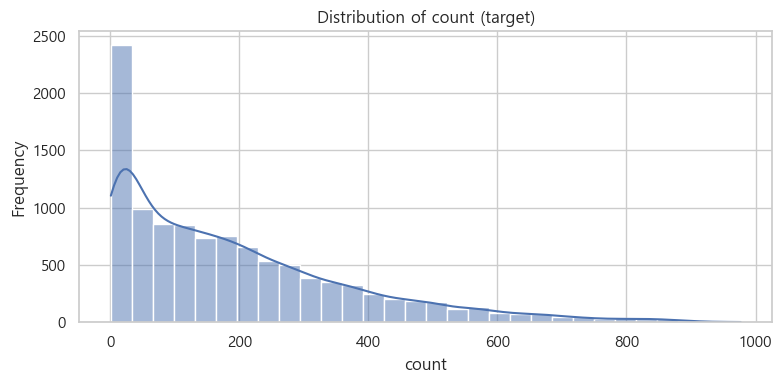

In [8]:
# 3-4. 타깃 변수(count)의 기본 분포 확인
plt.figure(figsize=(8, 4))
sns.histplot(train["count"], bins=30, kde=True)
plt.title("Distribution of count (target)")
plt.xlabel("count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

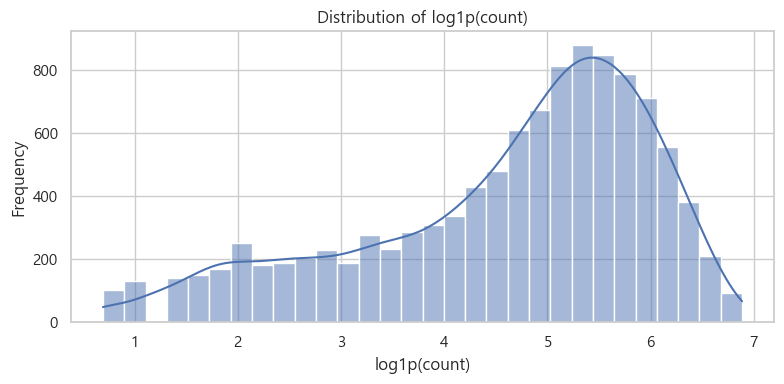

In [9]:
plt.figure(figsize=(8, 4))
sns.histplot(np.log1p(train["count"]), bins=30, kde=True)
plt.title("Distribution of log1p(count)")
plt.xlabel("log1p(count)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [10]:
print("\n=== 타깃 변수(count) 기초 통계량 ===")
print(train["count"].describe())


=== 타깃 변수(count) 기초 통계량 ===
count    10864.000000
mean       191.904731
std        181.174729
min          1.000000
25%         43.000000
50%        146.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64


# 4. 피처 엔지니어링 (datetime 기반 파생 변수 생성)

이 단계에서는 `datetime` 컬럼을 활용해 다음과 같은 시간 관련 파생 변수를 만든다.

- year: 연도
- month: 월 (1~12)
- day: 일 (1~31)
- hour: 시각 (0~23)
- dayofweek: 요일 (0=월요일, 6=일요일)
- is_weekend: 주말 여부 (0=평일, 1=주말)

이 변수들은 특정 시간대, 월, 요일, 주말/평일에 따라
자전거 대여 수요가 어떻게 달라지는지 분석하고 모델에 반영하기 위해 사용된다.

`train`과 `test` 데이터 모두 동일한 방식으로 변환한다.


### 4-1. `datetime` 컬럼을 datetime 타입으로 변환

In [11]:
# 4-1. datetime 컬럼을 datetime 타입으로 변환

# train 데이터
train["datetime"] = pd.to_datetime(train["datetime"])

# test 데이터
test["datetime"] = pd.to_datetime(test["datetime"])

print("train datetime dtype:", train["datetime"].dtype)
print("test datetime dtype :", test["datetime"].dtype)

train datetime dtype: datetime64[ns]
test datetime dtype : datetime64[ns]


### 4-2. 시간 관련 파생 변수 생성

In [12]:
# 4-2. datetime에서 파생 변수 생성

# 연도
train["year"] = train["datetime"].dt.year
test["year"] = test["datetime"].dt.year

# 월
train["month"] = train["datetime"].dt.month
test["month"] = test["datetime"].dt.month

# 일
train["day"] = train["datetime"].dt.day
test["day"] = test["datetime"].dt.day

# 시각(0~23)
train["hour"] = train["datetime"].dt.hour
test["hour"] = test["datetime"].dt.hour

# 요일(0=월요일, 6=일요일)
train["dayofweek"] = train["datetime"].dt.dayofweek
test["dayofweek"] = test["datetime"].dt.dayofweek

# 주말 여부 (토:5, 일:6 이면 1, 나머지는 0)
train["is_weekend"] = train["dayofweek"].isin([5, 6]).astype(int)
test["is_weekend"] = test["dayofweek"].isin([5, 6]).astype(int)

### 4-3. 파생 변수 생성 결과 간단 확인

In [13]:
# 4-3. 새로 만든 컬럼 일부 확인

cols_to_show = [
    "datetime", "year", "month", "day", "hour",
    "dayofweek", "is_weekend", "season", "holiday",
    "workingday", "weather", "count"
]

print(train[cols_to_show].head())

             datetime  year  month  day  hour  dayofweek  is_weekend  season  \
0 2011-01-01 00:00:00  2011      1    1     0          5           1       1   
1 2011-01-01 01:00:00  2011      1    1     1          5           1       1   
2 2011-01-01 02:00:00  2011      1    1     2          5           1       1   
3 2011-01-01 03:00:00  2011      1    1     3          5           1       1   
4 2011-01-01 04:00:00  2011      1    1     4          5           1       1   

   holiday  workingday  weather  count  
0        0           0        1     16  
1        0           0        1     40  
2        0           0        1     32  
3        0           0        1     13  
4        0           0        1      1  


# 5. 탐색적 데이터 분석 (EDA 2단계, 질문별 분석)

이 단계에서는 다음과 같은 질문을 중심으로 데이터를 탐색한다.

1. 특정 시간대의 자전거 대여 패턴은 무엇인가? (`hour`)
2. 날씨 관련 변수와 자전거 대여 수요 간의 관계는 어떠한가? (`temp`, `atemp`, `humidity`, `windspeed`, `weather`)
3. 계절별 자전거 대여 패턴은 어떻게 다른가? (`season`, `month`)
4. 주말과 평일, 요일별 자전거 대여 수요 차이는 어떠한가? (`workingday`, `dayofweek`, `is_weekend`)

각 질문별로 **시각화와 그룹 통계**를 통해 패턴을 확인하고,  
이후 모델링 단계에서 어떤 변수를 중요하게 다룰지에 대한 가설을 세운다.

### 5-1. 시간대별 자전거 대여 패턴

- `hour`(0~23시)별 평균 `count`를 확인하여,  
  하루 중 어떤 시간대에 자전거 대여가 집중되는지 살펴본다.
- 추가로, 근무일(`workingday`) 여부에 따라 시간대 패턴이 달라지는지도 확인한다.

   hour      count
0     0  55.253304
1     1  33.929360
2     2  22.948546
3     3  11.757506
4     4   6.407240


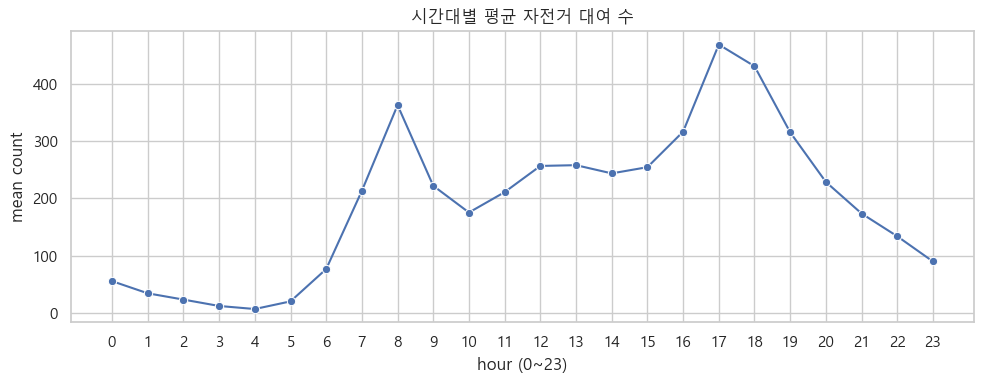

In [14]:
# 5-1. 시간대별 평균 대여 수

# 시간대별 평균 count
hourly_mean = train.groupby("hour")["count"].mean().reset_index()

print(hourly_mean.head())

plt.figure(figsize=(10, 4))
sns.lineplot(data=hourly_mean, x="hour", y="count", marker="o")
plt.title("시간대별 평균 자전거 대여 수")
plt.xlabel("hour (0~23)")
plt.ylabel("mean count")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

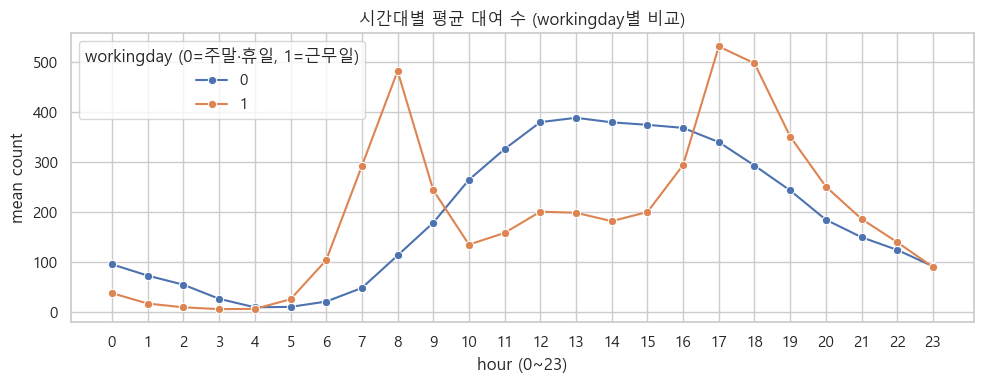

In [15]:
# 5-1-추가. 근무일(workingday) 여부에 따른 시간대별 패턴

hourly_working = train.groupby(["hour", "workingday"])["count"].mean().reset_index()

plt.figure(figsize=(10, 4))
sns.lineplot(
    data=hourly_working,
    x="hour",
    y="count",
    hue="workingday",
    marker="o"
)
plt.title("시간대별 평균 대여 수 (workingday별 비교)")
plt.xlabel("hour (0~23)")
plt.ylabel("mean count")
plt.xticks(range(0, 24))
plt.legend(title="workingday (0=주말·휴일, 1=근무일)")
plt.tight_layout()
plt.show()

### 5-2. 날씨 변수와 자전거 대여 수요 간의 관계

- 온도(`temp`, `atemp`), 습도(`humidity`), 풍속(`windspeed`)와 `count`의 상관관계를 확인한다.
- `weather`(1~4)에 따른 `count` 분포를 비교하여, 날씨 상태에 따라 수요가 어떻게 달라지는지 살펴본다.


count        1.000000
temp         0.393893
atemp        0.389269
windspeed    0.102502
humidity    -0.326956
Name: count, dtype: float64


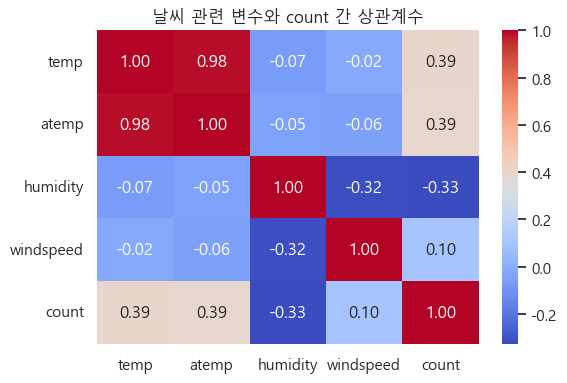

In [ ]:
# 5-2. 수치형 날씨 변수와 count의 상관관계

weather_cols = ["temp", "atemp", "humidity", "windspeed", "count"]
corr = train[weather_cols].corr()

print(corr["count"].sort_values(ascending=False))

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("날씨 관련 변수와 count 간 상관계수")
plt.tight_layout()
plt.show()

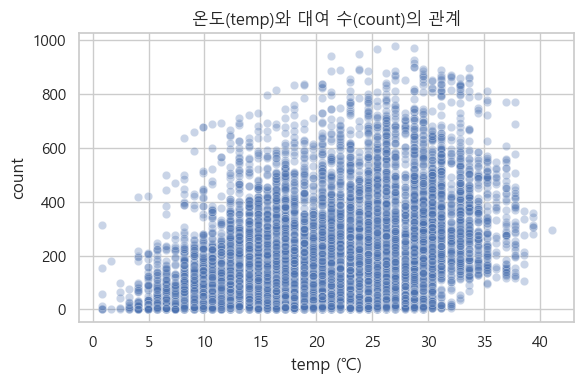

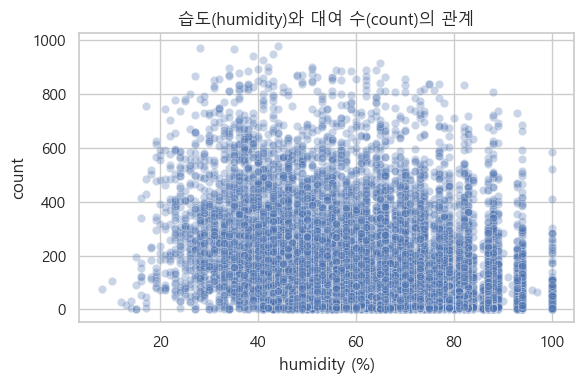

In [ ]:
# 5-2-1. temp vs count 산점도

plt.figure(figsize=(6, 4))
sns.scatterplot(data=train, x="temp", y="count", alpha=0.3)
plt.title("온도(temp)와 대여 수(count)의 관계")
plt.xlabel("temp (℃)")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# 5-2-2. humidity vs count 산점도

plt.figure(figsize=(6, 4))
sns.scatterplot(data=train, x="humidity", y="count", alpha=0.3)
plt.title("습도(humidity)와 대여 수(count)의 관계")
plt.xlabel("humidity (%)")
plt.ylabel("count")
plt.tight_layout()
plt.show()

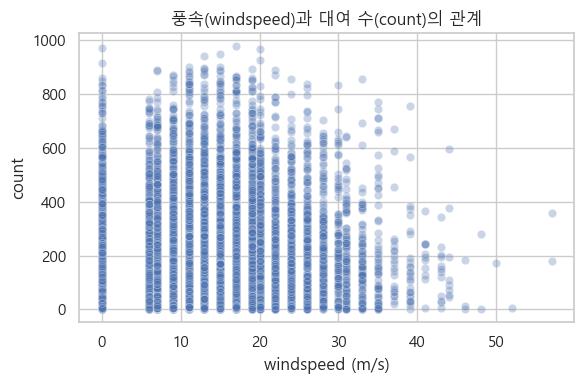

In [ ]:
# 5-2-3. windspeed vs count 산점도

plt.figure(figsize=(6, 4))
sns.scatterplot(data=train, x="windspeed", y="count", alpha=0.3)
plt.title("풍속(windspeed)과 대여 수(count)의 관계")
plt.xlabel("windspeed (m/s)")
plt.ylabel("count")
plt.tight_layout()
plt.show()

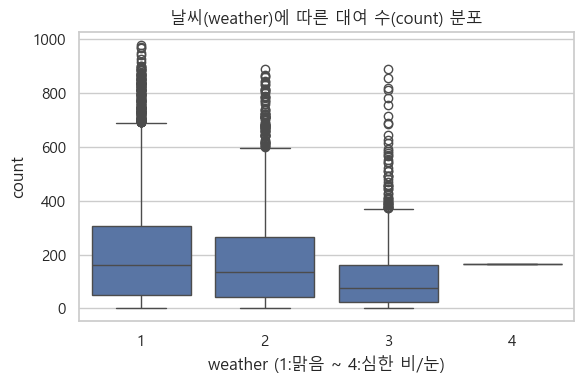

In [18]:
# 5-2-4. weather 별 count 분포 (boxplot)

plt.figure(figsize=(6, 4))
sns.boxplot(data=train, x="weather", y="count")
plt.title("날씨(weather)에 따른 대여 수(count) 분포")
plt.xlabel("weather (1:맑음 ~ 4:심한 비/눈)")
plt.ylabel("count")
plt.tight_layout()
plt.show()

### 5-3. 계절별 자전거 대여 패턴

- `season`(1:봄, 2:여름, 3:가을, 4:겨울)에 따른 `count` 분포를 비교한다.
- 필요하다면 `month`(월) 기준으로 더 세밀한 패턴도 확인한다.

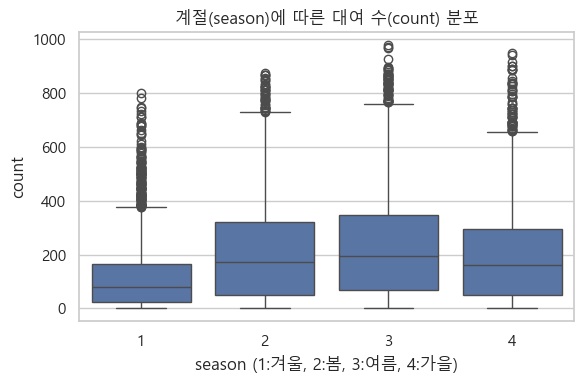

In [19]:
# 5-3-1. season별 count 분포 (boxplot)

plt.figure(figsize=(6, 4))
sns.boxplot(data=train, x="season", y="count")
plt.title("계절(season)에 따른 대여 수(count) 분포")
plt.xlabel("season (1:겨울, 2:봄, 3:여름, 4:가을)")
plt.ylabel("count")
plt.tight_layout()
plt.show()

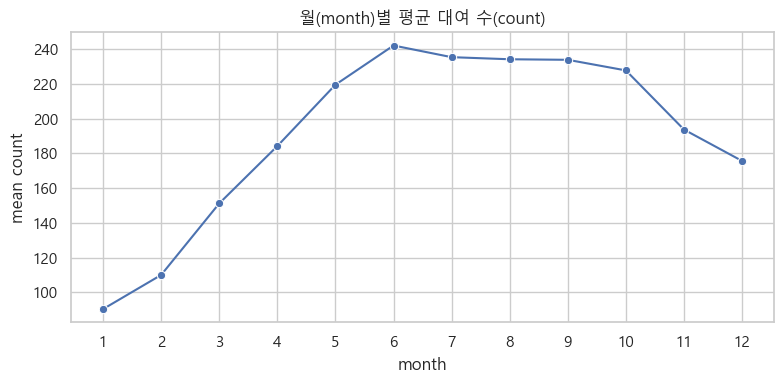

In [20]:
# 5-3-2. month별 평균 count (라인 플롯)

monthly_mean = train.groupby("month")["count"].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.lineplot(data=monthly_mean, x="month", y="count", marker="o")
plt.title("월(month)별 평균 대여 수(count)")
plt.xlabel("month")
plt.ylabel("mean count")
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

### 5-4. 주말/평일 및 요일별 대여 수요 차이

- 근무일(`workingday`) 여부에 따른 평균 `count`를 비교한다.
- `dayofweek`(0=월요일 ~ 6=일요일) 기준으로 요일별 평균 `count`를 확인한다.
- `is_weekend`(주말 여부) 기준으로도 비교해 본다.

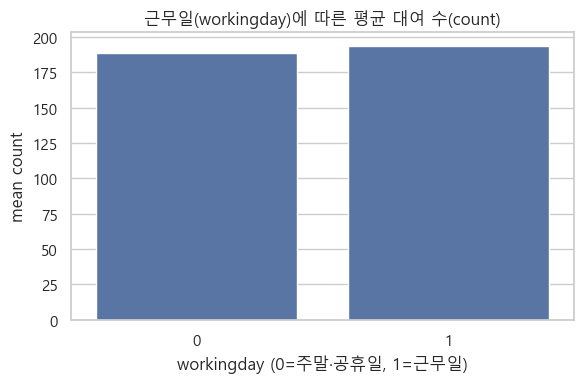

   workingday       count
0           0  188.506621
1           1  193.502165


In [21]:
# 5-4-1. workingday에 따른 평균 count 비교

workingday_mean = train.groupby("workingday")["count"].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(data=workingday_mean, x="workingday", y="count")
plt.title("근무일(workingday)에 따른 평균 대여 수(count)")
plt.xlabel("workingday (0=주말·공휴일, 1=근무일)")
plt.ylabel("mean count")
plt.tight_layout()
plt.show()

print(workingday_mean)

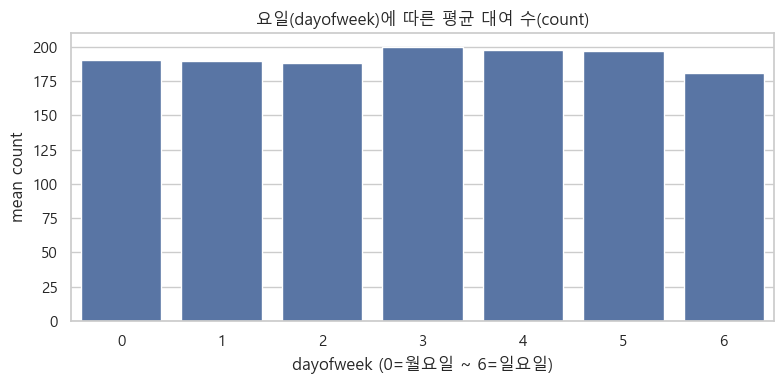

   dayofweek       count
0          0  190.390716
1          1  189.723847
2          2  188.411348
3          3  199.724363
4          4  197.844343
5          5  196.665404
6          6  180.839772


In [22]:
# 5-4-2. 요일별 평균 count (dayofweek)

dow_mean = train.groupby("dayofweek")["count"].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(data=dow_mean, x="dayofweek", y="count")
plt.title("요일(dayofweek)에 따른 평균 대여 수(count)")
plt.xlabel("dayofweek (0=월요일 ~ 6=일요일)")
plt.ylabel("mean count")
plt.tight_layout()
plt.show()

print(dow_mean)

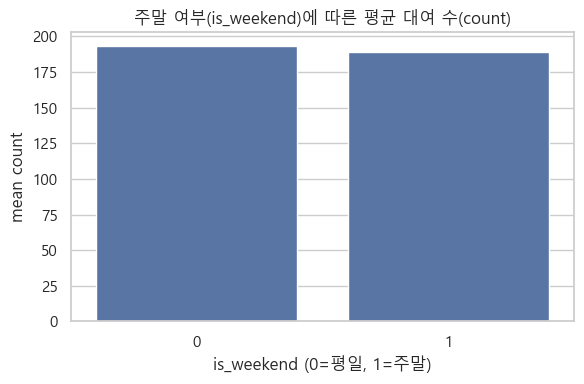

   is_weekend       count
0           0  193.194260
1           1  188.765096


In [23]:
# 5-4-3. 주말 여부(is_weekend)에 따른 평균 count

weekend_mean = train.groupby("is_weekend")["count"].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(data=weekend_mean, x="is_weekend", y="count")
plt.title("주말 여부(is_weekend)에 따른 평균 대여 수(count)")
plt.xlabel("is_weekend (0=평일, 1=주말)")
plt.ylabel("mean count")
plt.tight_layout()
plt.show()

print(weekend_mean)

# 6. 모델링 준비 (데이터 분리 & 평가 지표 정의)

이 단계에서는 본격적인 모델링 전에 다음 작업을 수행한다.

1. 타깃 변수(`count`)와 로그 변환된 타깃(`log1p(count)`)을 준비한다.
2. 모델에서 사용할 입력 피처(설명 변수) 목록을 정의한다.
3. 시간 순서를 고려하여 학습(train) / 검증(valid) 데이터를 분리한다.
4. 평가 지표인 RMSLE를 계산하는 함수를 정의한다.

※ RMSLE는 원래 스케일의 `count` 값(예측값과 실제값)에 대해 계산하며,  
   모델을 로그 스케일에서 학습하는 경우에는 예측 후 `expm1`으로 되돌린 뒤 RMSLE를 계산한다.

### 6-1. 타깃 변수 및 로그 변환 타깃 생성

In [24]:
# 6-1. 타깃 변수 및 로그 변환 타깃 생성

# 타깃 변수: count
y = train["count"].values

# 로그 변환된 타깃 (log1p: log(1 + x))
train["count_log"] = np.log1p(train["count"])
y_log = train["count_log"].values

print("원래 타깃(count) 예시:", y[:10])
print("로그 타깃(count_log) 예시:", y_log[:10])

원래 타깃(count) 예시: [16 40 32 13  1  1  2  3  8 14]
로그 타깃(count_log) 예시: [2.83321334 3.71357207 3.49650756 2.63905733 0.69314718 0.69314718
 1.09861229 1.38629436 2.19722458 2.7080502 ]


### 6-2. 입력 피처(X) 정의

In [25]:
# 6-2. 입력 피처(X) 정의

feature_cols = [
    "season",
    "holiday",
    "workingday",
    "weather",
    "temp",
    "atemp",
    "humidity",
    "windspeed",
    "year",
    "month",
    "day",
    "hour",
    "dayofweek",
    "is_weekend",
]

X = train[feature_cols].copy()

print("입력 피처 컬럼 수:", len(feature_cols))
print("X shape:", X.shape)
print("사용 피처 목록:", feature_cols)

입력 피처 컬럼 수: 14
X shape: (10864, 14)
사용 피처 목록: ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour', 'dayofweek', 'is_weekend']


### 6-3. 학습/검증 데이터 분리 (train_test_split)

모델 성능을 평가하기 위해 전체 데이터를 학습용(train)과 검증용(valid)으로 나눈다.

- `sklearn.model_selection`의 `train_test_split` 함수를 사용한다.
- 기본 설정으로 랜덤하게 섞은 뒤,
  - 80%: 학습용
  - 20%: 검증용
- 타깃은 로그 변환된 값 `count_log`를 사용해 모델을 학습하고,
  예측값은 `expm1`으로 되돌린 후 RMSLE를 계산한다.

In [26]:
# 6-3. 학습/검증 데이터 분리 (sklearn train_test_split 사용)

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid, y_log_train, y_log_valid = train_test_split(
    X,                  # X -> 입력 피처 (feature_cols)
    y,                  # y -> 원래 타깃 (count)
    y_log,              # y_log   -> 로그 타깃 (log1p(count))
    test_size=0.2,      # 20%를 검증용으로 사용
    random_state=42,    # 재현 가능성을 위한 시드
    shuffle=True        # 기본값(True) - 무작위 섞기
)

print("전체 샘플 수:", len(X))
print("train 크기:", X_train.shape[0])
print("valid 크기:", X_valid.shape[0])

전체 샘플 수: 10864
train 크기: 8691
valid 크기: 2173


### 6-4. RMSLE 평가 함수 정의

In [27]:
# 6-4. RMSLE 평가 함수 정의 (scikit-learn 활용)

from sklearn.metrics import mean_squared_log_error

def rmsle(y_true, y_pred):
    """
    y_true, y_pred: 원래 스케일의 count 값 (0 이상)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 음수 예측 방지 (혹시 모델이 음수 예측하면 0으로 올려줌)
    y_pred = np.where(y_pred < 0, 0, y_pred)

    msle = mean_squared_log_error(y_true, y_pred)
    return np.sqrt(msle)


# 간단 테스트
test_true = [0, 10, 20, 50]
test_pred = [0, 12, 18, 60]

print("테스트 RMSLE:", rmsle(test_true, test_pred))

테스트 RMSLE: 0.13227058919539245


# 7. 다양한 회귀 모델 실험 및 RMSLE 비교

이 단계에서는 여러 종류의 회귀 모델을 학습시키고,  
검증 데이터에 대한 **RMSLE**를 비교함으로써 성능을 평가한다.

사용하는 모델은 다음과 같다.

1. **베이스라인 모델**
   - `Baseline_mean`: `y_train`의 전체 평균으로만 예측
   - `Baseline_hour`: `hour`별 평균 대여 수로 예측
2. **단순선형회귀 (Simple Linear Regression)**
   - 설명 변수 1개(`temp`)만 사용
3. **다중선형회귀 (Multiple Linear Regression)**
   - 여러 설명 변수(`feature_cols`)를 동시에 사용하는 선형 회귀
4. **다항회귀 (Polynomial Regression)**
   - `temp`와 그 제곱항(`temp^2`)을 사용해 곡선 관계를 표현하는 회귀
5. **SVM 회귀 (SVR, Support Vector Regression)**
   - 커널 기반 비선형 회귀 모델

모든 회귀 모델은 **로그 변환된 타깃(`log1p(count)`)** 으로 학습하고,  
예측값은 `expm1`으로 되돌린 뒤 **RMSLE**로 평가한다.

이 과정을 통해,

- 단순한 선형 모델에서 점점 더 복잡한 모델로 갈수록 성능이 어떻게 변하는지,
- 베이스라인 대비 머신러닝 모델이 얼마나 성능을 개선하는지

를 확인하는 것이 목표이다.

### 7-1. 베이스라인 모델

In [28]:
# 7-1. 베이스라인 모델 (평균 / 시간대별 평균)

results = {}  # 모델별 RMSLE를 저장할 딕셔너리

# 7-1-1. 전체 평균으로 예측 (Baseline_mean)
baseline_mean = y_train.mean()
y_pred_baseline_mean = np.full_like(y_valid, fill_value=baseline_mean, dtype=float)

baseline_mean_rmsle = rmsle(y_valid, y_pred_baseline_mean)
results["Baseline_mean"] = baseline_mean_rmsle

print(f"[Baseline_mean] RMSLE: {baseline_mean_rmsle:.5f}")


# 7-1-2. 시간대(hour)별 평균으로 예측 (Baseline_hour)

# X_train, X_valid에는 'hour' 컬럼이 포함되어 있다고 가정
hour_mean = (
    pd.DataFrame({"hour": X_train["hour"], "count": y_train})
    .groupby("hour")["count"]
    .mean()
)

# 검증 세트의 hour를 기준으로 매핑
y_pred_baseline_hour = X_valid["hour"].map(hour_mean)

# 혹시 NaN이 있으면 전체 평균으로 대체 (이론상 거의 없음)
y_pred_baseline_hour = y_pred_baseline_hour.fillna(baseline_mean)

baseline_hour_rmsle = rmsle(y_valid, y_pred_baseline_hour.values)
results["Baseline_hour"] = baseline_hour_rmsle

print(f"[Baseline_hour] RMSLE: {baseline_hour_rmsle:.5f}")

[Baseline_mean] RMSLE: 1.59745
[Baseline_hour] RMSLE: 0.83695


### 7-2. 단순선형회귀 (Simple Linear Regression, temp만 사용)

In [29]:
# 7-2. 단순선형회귀 (Simple Linear Regression: temp 하나만 사용)

from sklearn.linear_model import LinearRegression

# 설명 변수 하나만 사용: temp
X_train_simple = X_train[["temp"]]
X_valid_simple = X_valid[["temp"]]

lin_reg_simple = LinearRegression()
lin_reg_simple.fit(X_train_simple, y_log_train)  # 로그 타깃으로 학습

# 검증 세트 예측 (로그 스케일)
y_log_pred_simple = lin_reg_simple.predict(X_valid_simple)

# 원래 스케일로 변환
y_pred_simple = np.expm1(y_log_pred_simple)

simple_rmsle = rmsle(y_valid, y_pred_simple)
results["SimpleLinear(temp)"] = simple_rmsle

print(f"[SimpleLinear(temp)] RMSLE: {simple_rmsle:.5f}")

[SimpleLinear(temp)] RMSLE: 1.33904


### 7-3. 다중선형회귀 (Multiple Linear Regression, feature_cols 전체 사용)

In [30]:
# 7-3. 다중선형회귀 (Multiple Linear Regression: feature_cols 전체 사용)

lin_reg_multi = LinearRegression()
lin_reg_multi.fit(X_train, y_log_train)  # 여러 피처 + 로그 타깃

# 검증 세트 예측 (로그 스케일)
y_log_pred_multi = lin_reg_multi.predict(X_valid)

# 원래 스케일로 변환
y_pred_multi = np.expm1(y_log_pred_multi)

multi_rmsle = rmsle(y_valid, y_pred_multi)
results["MultipleLinear"] = multi_rmsle

print(f"[MultipleLinear] RMSLE: {multi_rmsle:.5f}")

[MultipleLinear] RMSLE: 1.02984


### 7-4. 다항회귀 (Polynomial Regression, temp + temp^2)

In [31]:
# 7-4. 다항회귀 (Polynomial Regression: temp, temp^2 사용)

from sklearn.preprocessing import PolynomialFeatures

poly_degree = 2

# temp 하나를 입력으로, 2차 다항식까지 확장
poly = PolynomialFeatures(degree=poly_degree, include_bias=True)

# 학습용 변환
X_train_simple_poly = poly.fit_transform(X_train_simple)   # (temp → [1, temp, temp^2])
X_valid_simple_poly = poly.transform(X_valid_simple)

lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_train_simple_poly, y_log_train)

# 검증 세트 예측 (로그 스케일)
y_log_pred_poly = lin_reg_poly.predict(X_valid_simple_poly)

# 원래 스케일로 변환
y_pred_poly = np.expm1(y_log_pred_poly)

poly_rmsle = rmsle(y_valid, y_pred_poly)
results[f"Polynomial(degree={poly_degree})"] = poly_rmsle

print(f"[Polynomial(degree={poly_degree})] RMSLE: {poly_rmsle:.5f}")

[Polynomial(degree=2)] RMSLE: 1.33876


### 7-5. SVM 회귀 (SVR + StandardScaler)

In [32]:
# 7-5. SVM 회귀 (SVR + StandardScaler 수동 적용)

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# 1) 피처 스케일링
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# 2) SVR 모델 정의
svr = SVR(kernel="rbf", C=10.0, epsilon=0.1)

# 3) 학습 (로그 타깃 사용)
svr.fit(X_train_scaled, y_log_train)

# 4) 검증 세트 예측 (로그 스케일)
y_log_pred_svr = svr.predict(X_valid_scaled)

# 5) 원래 스케일로 변환
y_pred_svr = np.expm1(y_log_pred_svr)

svr_rmsle = rmsle(y_valid, y_pred_svr)
results["SVR"] = svr_rmsle

print(f"[SVR] RMSLE: {svr_rmsle:.5f}")


[SVR] RMSLE: 0.77508


### 7-6. 모델별 RMSLE 비교 정리

=== 모델별 RMSLE 비교 ===
                  model     rmsle
0                   SVR  0.775083
1         Baseline_hour  0.836949
2        MultipleLinear  1.029837
3  Polynomial(degree=2)  1.338757
4    SimpleLinear(temp)  1.339045
5         Baseline_mean  1.597449


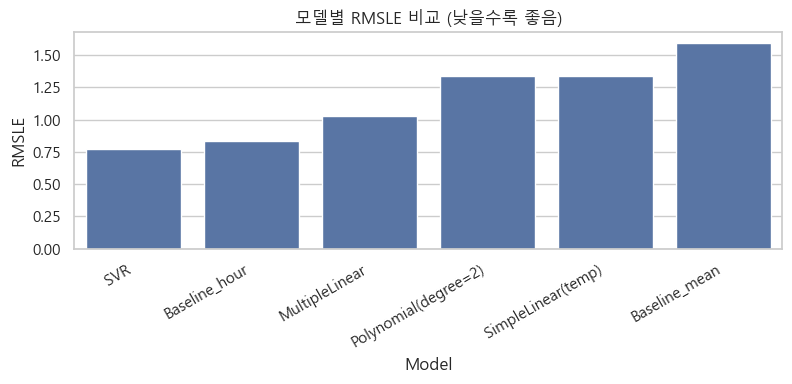

In [33]:
# 7-6. 모델별 RMSLE 비교 및 시각화

results_df = (
    pd.DataFrame(list(results.items()), columns=["model", "rmsle"])
    .sort_values("rmsle")
    .reset_index(drop=True)
)

print("=== 모델별 RMSLE 비교 ===")
print(results_df)

plt.figure(figsize=(8, 4))
sns.barplot(data=results_df, x="model", y="rmsle")
plt.title("모델별 RMSLE 비교 (낮을수록 좋음)")
plt.xlabel("Model")
plt.ylabel("RMSLE")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


# 8. 최종 모델(SVR) 선택 및 test 예측

7단계에서 여러 회귀 모델의 RMSLE를 비교한 결과,  
**SVR(Support Vector Regression)** 이 가장 낮은 RMSLE를 보여 최종 모델로 선택하였다.

이 단계에서는

1. 전체 학습 데이터(`X`, `y_log`)를 사용해 SVR 모델을 다시 학습하고,
2. 동일한 전처리(표준화)를 적용한 뒤 test 데이터에 대한 예측값(`count`)을 생성하며,
3. 제출/분석용 결과 파일을 저장한다.

예측은 로그 스케일에서 수행한 뒤 `expm1`으로 되돌려 원래 `count` 단위로 변환하고,  
음수 예측값은 0으로 보정한 후 정수로 반올림하여 제출값을 생성한다.

### 8-1. 최종 모델(SVR) 전체 train으로 재학습

In [34]:
# 8-1. 최종 모델(SVR)을 전체 train 데이터로 재학습

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# 1) 전체 train 피처/타깃 (6단계에서 이미 정의된 X, y_log 사용)
# X: feature_cols 전체
# y_log: log1p(count)

scaler_final = StandardScaler()
X_scaled_full = scaler_final.fit_transform(X)

svr_final = SVR(kernel="rbf", C=10.0, epsilon=0.1)

svr_final.fit(X_scaled_full, y_log)

print("최종 SVR 모델 학습 완료")

최종 SVR 모델 학습 완료


### 8-2. test 데이터 피처 구성 및 스케일링

In [35]:
# 8-2. test 데이터 피처 구성 및 스케일링

# feature_cols는 6단계에서 정의한 것과 동일하게 사용
X_test_final = test[feature_cols].copy()
X_test_scaled = scaler_final.transform(X_test_final)

print("X_test_final shape:", X_test_final.shape)

X_test_final shape: (6493, 14)


### 8-3. test 예측값 생성 (로그 → 원래 스케일)

In [36]:
# 8-3. test 데이터 예측 (로그 스케일 → 원래 스케일)

# 1) 로그 스케일에서 예측
y_log_pred_test = svr_final.predict(X_test_scaled)

# 2) 원래 스케일(count)로 변환
y_pred_test = np.expm1(y_log_pred_test)

# 3) 음수 예측값은 0으로 보정
y_pred_test = np.where(y_pred_test < 0, 0, y_pred_test)

# 4) 정수형으로 반올림 (자전거 대여 수는 정수)
y_pred_test_rounded = np.round(y_pred_test).astype(int)

print("예측값 예시 (앞 10개):", y_pred_test_rounded[:10])

예측값 예시 (앞 10개): [ 4  8  9  7 10 12 17 25 32 37]


### 8-4. 제출/분석용 DataFrame 생성 & CSV 저장

In [37]:
# 8-4. 제출/분석용 결과 DataFrame 생성 및 저장

submission = pd.DataFrame({
    "datetime": test["datetime"],
    "count": y_pred_test_rounded
})

print(submission.head())

output_path = "./content/submission_svr.csv"
submission.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"\n 예측 결과 저장 완료: {output_path}")

             datetime  count
0 2011-01-20 00:00:00      4
1 2011-01-20 01:00:00      8
2 2011-01-20 02:00:00      9
3 2011-01-20 03:00:00      7
4 2011-01-20 04:00:00     10

 예측 결과 저장 완료: ./content/submission_svr.csv
